In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
from scipy.fft import rfft, rfftfreq
import json
import pandas as pd
import os
import matplotlib as mpl



In [12]:
MASTER_DIR = "../../results_new_septa/short_run/"

In [78]:
".DS_store".islower()

False

In [79]:
data = {}
for dir in [dir for dir in os.listdir(MASTER_DIR) if dir.startswith("gain_")]:
    gain = dir.split("_")[1]
    tf_df = pd.DataFrame(columns=["driving_frequency", "spill_to_signal"])
    rundirs = [d for d in os.listdir(MASTER_DIR + dir) if not d.isalpha() and not d==".DS_Store"]
    rundirs.sort(key = lambda d: float(d))
    print(dir, rundirs)

gain_0.1 ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
gain_0.02 ['1', '2']
gain_0.05 ['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
gain_0.15 ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
gain_0.075 ['0.1', '0.2', '0.3', '0.4', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
gain_0.01 ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']


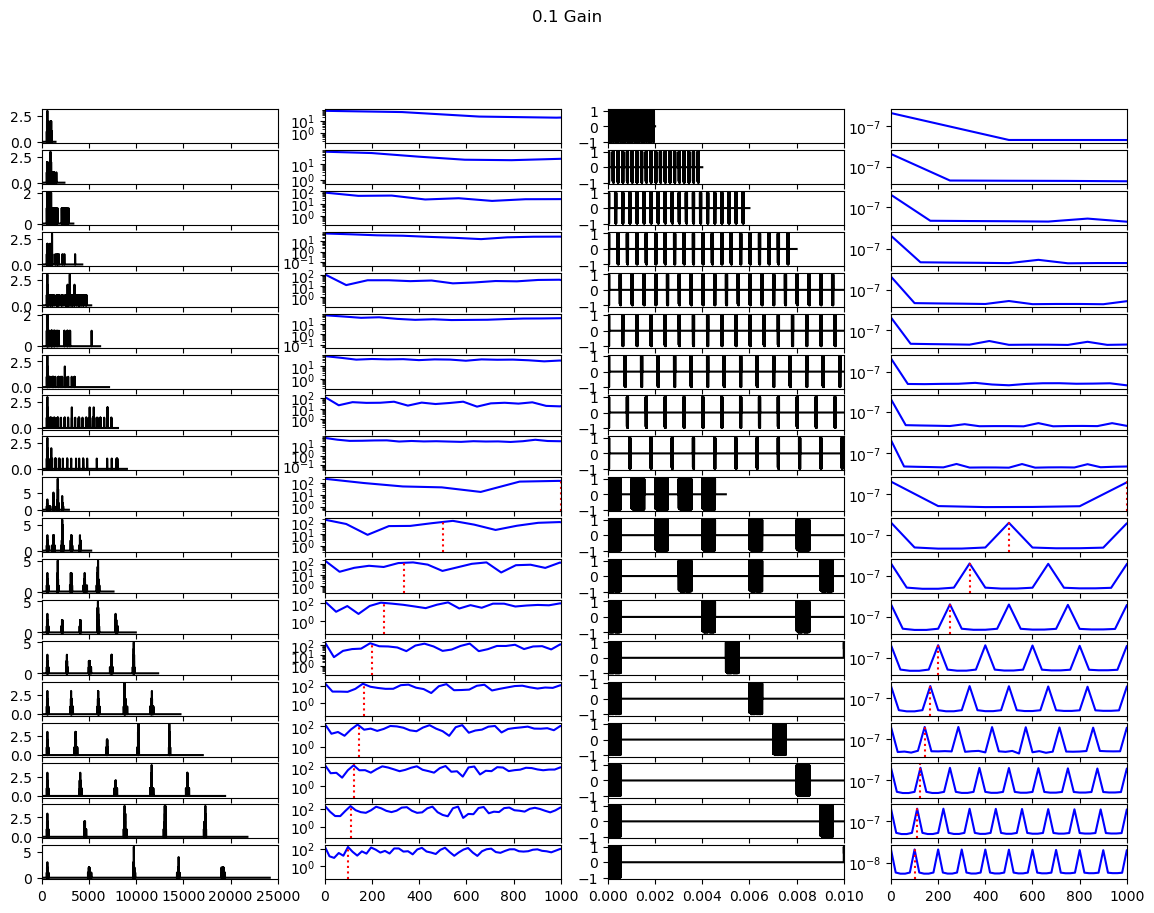

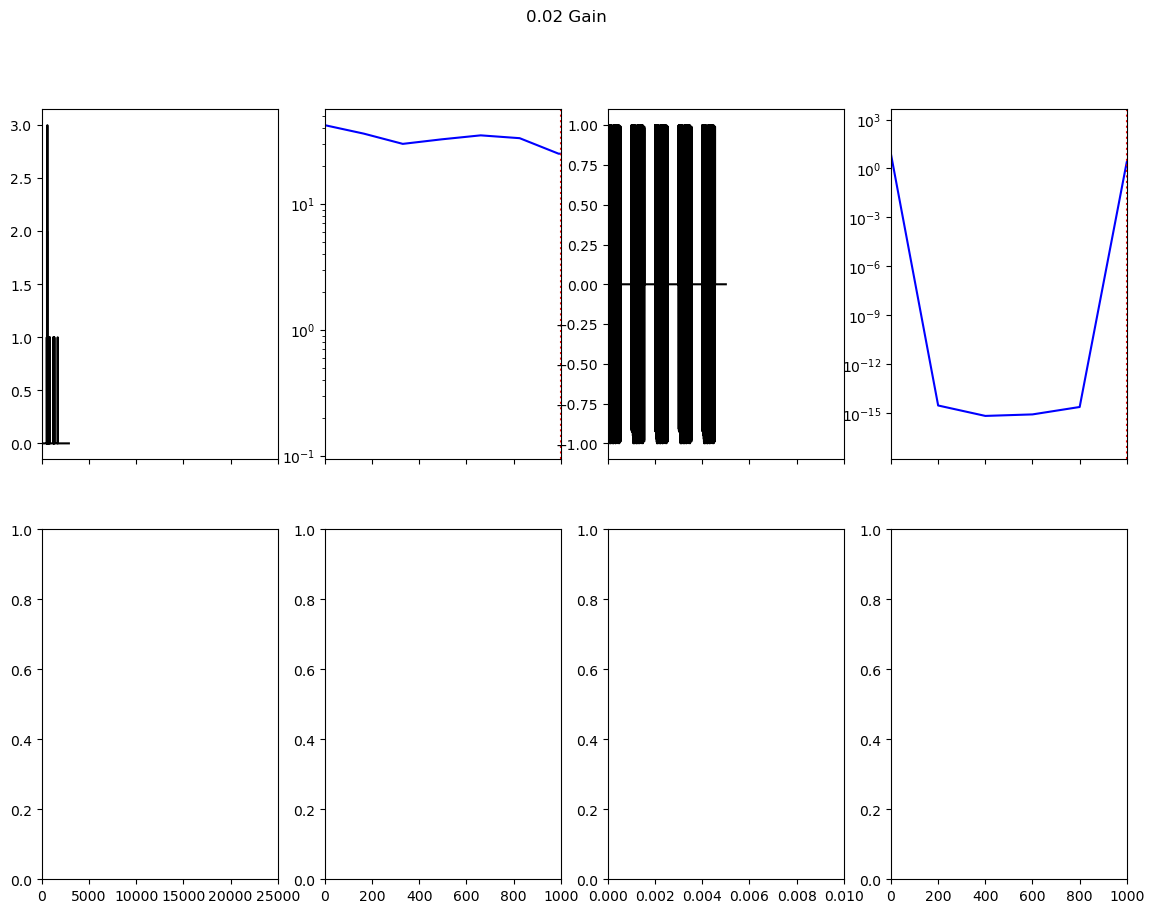

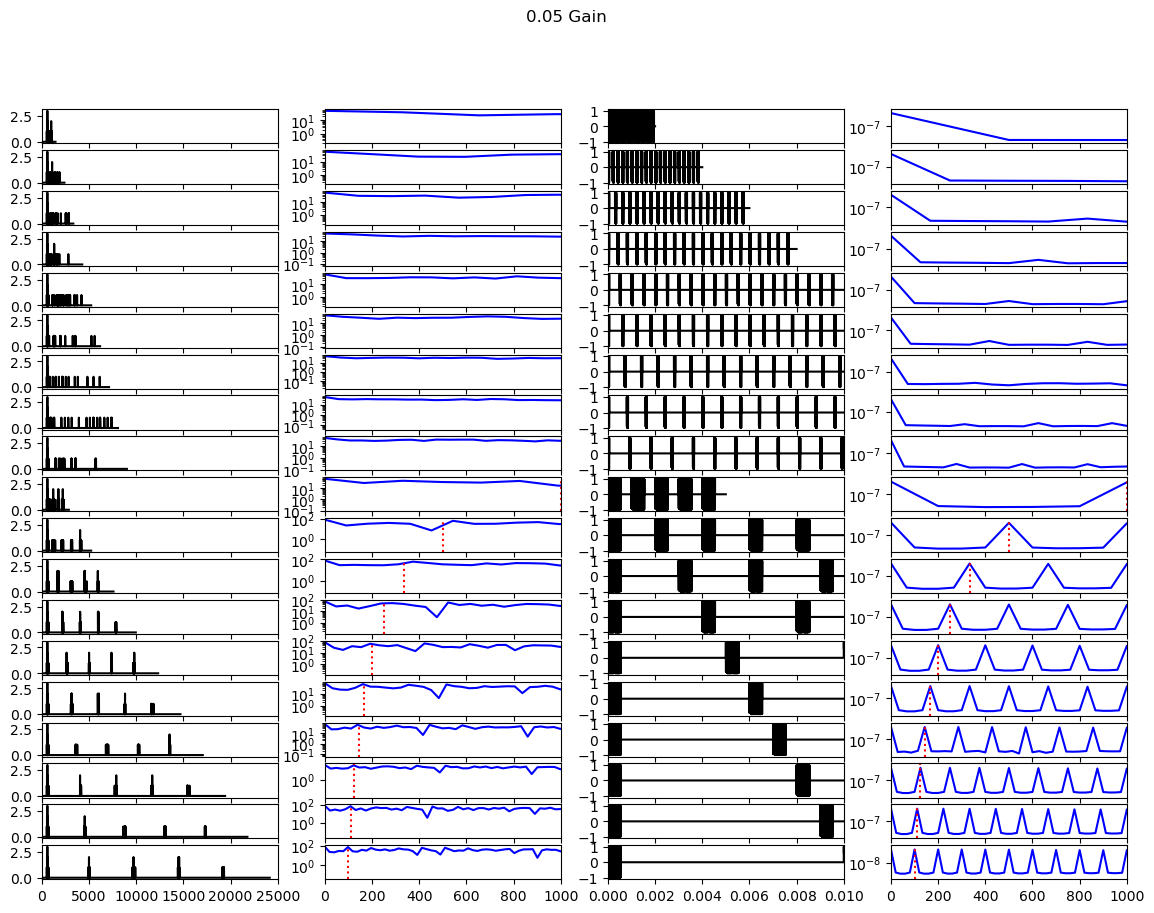

In [86]:
data = {}
for dir in [dir for dir in os.listdir(MASTER_DIR) if dir.startswith("gain_")]:
    gain = dir.split("_")[1]
    tf_df = pd.DataFrame(columns=["driving_frequency", "spill_to_signal"])
    rundirs = [d for d in os.listdir(MASTER_DIR + dir) if not d.isalpha() and not d==".DS_Store"]
    rundirs.sort(key = lambda d: float(d))

    fig, ax = plt.subplots(len(rundirs), 4, figsize=(14, 10), sharex='col')
    fig.suptitle(f"{gain} Gain")

    for i, d in enumerate(rundirs):
        try:
            chirp_sig = pkl.load(open(MASTER_DIR + dir + "/" + d + "/chirp_signal.pkl", "rb"))
            # load chirp_time.pkl
            chirp_time = pkl.load(open(MASTER_DIR + dir + "/" + d + "/chirp_time.pkl", "rb"))
            # load turn_counts.pkl
            turn_counts = pkl.load(open(MASTER_DIR + dir + "/" + d + "/turn_counts.pkl", "rb"))
            particles = pd.read_parquet(MASTER_DIR + dir + "/" + d + "/particles.parquet")
            chirp_fft_y = rfft(chirp_sig)
            chirp_fft_x = rfftfreq(len(chirp_sig), d=1/1e6)

            constants = json.load(open(MASTER_DIR + dir + "/" + d + "/constants.json", "r"))
            driving_interval = constants['rfko']['CHIRP_INTERVAL']
            driving_frequency = 1/driving_interval
            # Spill
            FREV = 1/473128.56479373755
            counts_fft_y = rfft(turn_counts)
            counts_fft_x = rfftfreq(len(turn_counts), d = FREV)

            ax[i, 0].plot(turn_counts, 'k')
            ax[i, 0].set_xlim(0, 25000)
            ax[i, 1].plot(counts_fft_x, np.abs(counts_fft_y), 'b-')
            ax[i, 1].set_xlim(0, 1000)
            ax[i, 1].set_yscale("log")

            def find_nearest(array, value):
                idx = (np.abs(array - value)).argmin()
                return idx
            counts_nearest_to_driving = find_nearest(counts_fft_x, driving_frequency)
            counts_nearest_value = counts_fft_y[counts_nearest_to_driving]
            # Signal
            try: 
                ax[i, 2].plot(chirp_time, chirp_sig[:len(chirp_time)], 'k')
            except ValueError:
                ax[i, 2].plot(chirp_time[:len(chirp_sig)], chirp_sig, 'k')
            ax[i, 2].set_xlim(0, 0.01)
            ax[i, 3].plot(chirp_fft_x, np.abs(chirp_fft_y), 'b-')
            ax[i, 3].set_xlim(0, 1000)
            ax[i, 3].set_yscale("log")

            ax[i, 1].axvline(driving_frequency, color='r', linestyle=':')
            ax[i, 3].axvline(driving_frequency, color='r', linestyle=':')

            chirp_nearest_to_driving = find_nearest(chirp_fft_x, driving_frequency)
            chirp_nearest_value = chirp_fft_y[chirp_nearest_to_driving]
        
            data_point = (np.abs(driving_frequency), np.abs(counts_nearest_value/chirp_nearest_value))
            tf_df.loc[len(tf_df)] = data_point
        except FileNotFoundError:
            pass
    data[gain] = tf_df

(900.0, 10000.0)

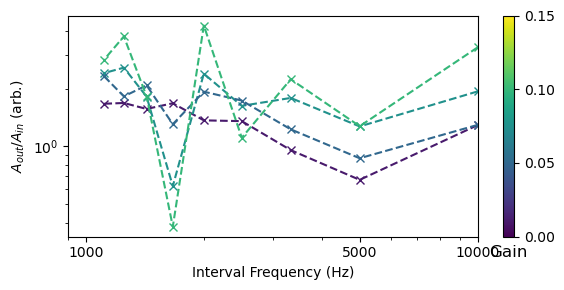

In [97]:
gains = [float(d) for d in data.keys()]
fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
cmap = plt.get_cmap('viridis')

#for gain in sorted(list(data.keys()), key = lambda d: float(d)):
for gain in ['0.01', '0.075', '0.05', '0.1']:
    lines = ax.plot(data[gain]['driving_frequency'][:9], data[gain]['spill_to_signal'][:9], 'x--', label=f"Gain: {gain}", c=cmap((1/max(gains))*float(gain)))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Interval Frequency (Hz)')
ax.set_ylabel(r'$A_{out}/A_{in}$ (arb.)')
#ax.set_title('Simulated fixed Amplitude Transfer Function\nof RFKO Slow Extraction')
ax.set_xticks([100, 500, 1000, 5000, 10000])
ax.set_xticklabels([100, 500, 1000, 5000, 10000])

norm = mpl.colors.Normalize(vmin=0, vmax=max(gains))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = plt.colorbar(sm,
             ticks = [0, 0.05, 0.1, 0.15])
cb.ax.set_title('Gain', y=-0.13)
ax.set_xlim(900, 10000)
#ax.text(x=350, y=2.2*10**1, s=r'$DRAFT$', color='red', alpha=.2, fontsize=100, ha='center', va='center')